In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import sys
sys.path.append("../")

from shared_utils.generate import format_conversation, transform_conversations
from early_exit.util import module_name_is_layer_base
import numpy as np

from shared_utils.data import CSVPromptDataset
from shared_utils.load import get_model, get_tokenizer, configs_from_yaml
from shared_utils.generate import generate_text

from early_exit.patching import replace_attention_layers, set_transformer_early_exit_mode

from shared_utils.load import get_model, get_tokenizer, configs_from_yaml
import random

import torch
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader

import sys
sys.path.append("../")

from shared_utils.data import CSVPromptDataset
from shared_utils.load import get_model, get_tokenizer, configs_from_yaml
from shared_utils.generate import generate_text

from early_exit.patching import replace_attention_layers, set_transformer_early_exit_mode

import wandb
import pandas as pd
import numpy as np


In [8]:
import torch.nn as nn
from collections import defaultdict
from functools import partial

class ActivationLens:
    """
    A utility class to hook multiple layers of a PyTorch model and collect their
    activations during a forward pass. It is designed for analyses like "Logic Lens,"
    where you want to inspect the intermediate representations of a model.

    The class can be used as a context manager to ensure hooks are automatically removed.

    Attributes:
        activations (defaultdict): A dictionary mapping layer_path (str) to a list
                                   of activation tensors from that layer.
    """

    def __init__(self):
        """Initializes the ActivationLens."""
        self.activations = defaultdict(list)
        self._hook_handles = []
        self._model = None

    def _create_hook_fn(self, layer_path: str):
        """
        Factory function to create a hook function for a specific layer.
        The created hook function knows its layer_path and stores the activation
        in the correct place in our `activations` dictionary.
        """
        def _hook_fn(module, input_tensors, output_tensor):
            # The output of some layers might be a tuple; we're often interested in the first element.
            activation = output_tensor[0] if isinstance(output_tensor, tuple) else output_tensor
            self.activations[layer_path].append(activation.detach().cpu())
        return _hook_fn

    def register(self, model: nn.Module, layer_paths: list[str]):
        """
        Registers forward hooks to a list of specific layers within the model.

        Args:
            model (nn.Module): The model to hook.
            layer_paths (list[str]): A list of dot-separated string paths to the target layers.
        """
        self._model = model
        self.remove_hooks() # Clear any existing hooks before registering new ones

        for path in layer_paths:
            try:
                # Navigate to the target layer
                target_layer = model
                for part in path.split('.'):
                    target_layer = getattr(target_layer, part)

                # Register the hook and store the handle
                hook_fn = self._create_hook_fn(path)
                handle = target_layer.register_forward_hook(hook_fn)
                self._hook_handles.append(handle)
                print(f"✅ Hook registered on '{type(target_layer).__name__}' at: {path}")

            except AttributeError:
                print(f"⚠️ Error: Could not find layer at path: {path}. Skipping.")
    
    def remove_hooks(self):
        """Removes all registered hooks."""
        for handle in self._hook_handles:
            handle.remove()
        self._hook_handles = []

    def clear_activations(self):
        """Clears all collected activations, but leaves the hooks in place."""
        self.activations.clear()

    # --- Context Manager Methods for clean, automatic hook removal ---
    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        # When the `with` block is exited, automatically remove all hooks
        self.remove_hooks()
        print("\n✨ All hooks automatically removed.")

In [9]:
# LOAD IN EXPERIMENT ARGS
# num_epoch = 1                     # args.num_epoch
num_exit_samples = 1                  # args.num_exit_samples
device = "cuda"                    # args.device
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"                    # args.model_name
model_config_path = "../config_deepseek.yaml"                     # args.model_config_path
dataset_path = "../results_and_data/early_exit_sft_dataset/test/data.csv"                  # args.dataset_path
prompt_config_path = "../results_and_data/early_exit_sft_dataset/test/prompt_config.json"                    # args.prompt_config_path
batch_size = 1                    # args.batch_size -- might want to sort out batching, but increasing num_exit_samples might be better + less effort

# LOAD IN THE MODEL AND TOKENIZER
tokenizer = get_tokenizer(model_name)
config = configs_from_yaml(model_config_path, tokenizer.eos_token_id)
model = get_model(model_name, config['model'], device)


# LOAD IN DATASET
dataset = CSVPromptDataset(dataset_path, prompt_config_path)
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=True)


# ENABLE EARLY EXITING
model = replace_attention_layers(model, config['lora'], device)

replacing layer model.layers.0
replacing layer model.layers.5
replacing layer model.layers.10
replacing layer model.layers.15
replacing layer model.layers.20
replacing layer model.layers.25
address this hack!
trainable params: 2,179,072 || all params: 1,779,276,294 || trainable%: 0.1225


In [34]:
import torch
import torch.nn.functional as F
import pandas as pd
from collections import defaultdict

# NOTE: This script assumes the ActivationLens class is defined as before.

# 1. Define the layers you want to inspect
num_layers = 28 # To include layers 0 through 27
layer_paths_to_hook = [f'base_model.model.model.layers.{i}' for i in range(num_layers)]
layer_paths_to_hook.append('base_model.model.model.norm')

print(f"Intending to hook {len(layer_paths_to_hook)} layers...")

# 2. Instantiate the lens and run the model
lens = ActivationLens()
lens.register(model, layer_paths_to_hook)

prompt = "Explain the concept of recursion in programming."
system_prompt = "You are a helpful programming tutor."
prefiller = ""

with torch.no_grad():
    # --- FIX ---
    # Correct the unpacking to match what generate_text actually returns.
    # It returns a tuple with only ONE item: generated_tokens.
    decoded_response, (generated_tokens,) = generate_text(
        model=model,
        prompt=prompt,
        system_prompt=system_prompt,
        prefiller=prefiller,
        tokenizer=tokenizer,
        generation_config=config['generation'],
        device=device
    )

# 3. Process activations and create the DataFrame
results_data = []
print("\nProcessing activations from each layer...")

for path, layer_activations_list in lens.activations.items():
    if not layer_activations_list:
        continue

    full_sequence_hidden_states = torch.cat(layer_activations_list, dim=1).to(device)
    logits_from_layer = model.early_exit_hidden_state_readout(full_sequence_hidden_states)
    predicted_token_ids = logits_from_layer.argmax(-1)
    text_from_layer = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)

    try:
        layer_num = int(path.split('.')[4]) if 'layers' in path else 'Final Norm'
    except (IndexError, ValueError):
        layer_num = path

    results_data.append({
        "layer_num": layer_num,
        "generated_text": text_from_layer,
        "logits": logits_from_layer.cpu()
    })

output_df = pd.DataFrame(results_data)
output_df = output_df.sort_values(
    by='layer_num',
    key=lambda col: pd.to_numeric(col, errors='coerce').fillna(float('inf'))
).set_index('layer_num')


# --- 4. NEW: Calculate Early Exit Probs from the DataFrame ---
# We can reconstruct the necessary tensors from the 'logits' column we saved.

print("\nCalculating Early Exit Probabilities...")

# Get the final layer's logits and convert them to log-probabilities
final_layer_logits = output_df.loc['Final Norm']['logits'].to(device)
sft_teacher_final_layer_logprobs = F.log_softmax(final_layer_logits, dim=-1)

# Get the logits from all intermediate layers and stack them
# This creates the `early_output_log_probs` tensor
intermediate_logits = output_df.drop('Final Norm')['logits'].tolist()
early_output_log_probs = torch.stack(intermediate_logits).to(device)

# Now you can calculate the early exit probabilities
early_exit_probs = model.early_exit_target_probs(
    early_output_log_probs=early_output_log_probs,
    teacher_final_layer_log_probs=sft_teacher_final_layer_logprobs
)

print("\n--- output_df ---")
print(output_df)


# Clean up the hooks
lens.remove_hooks()

Intending to hook 31 layers...
✅ Hook registered on 'DynamicallyTypedLayerWithExit' at: base_model.model.model.layers.0
✅ Hook registered on 'Qwen2DecoderLayer' at: base_model.model.model.layers.1
✅ Hook registered on 'Qwen2DecoderLayer' at: base_model.model.model.layers.2
✅ Hook registered on 'Qwen2DecoderLayer' at: base_model.model.model.layers.3
✅ Hook registered on 'Qwen2DecoderLayer' at: base_model.model.model.layers.4
✅ Hook registered on 'DynamicallyTypedLayerWithExit' at: base_model.model.model.layers.5
✅ Hook registered on 'Qwen2DecoderLayer' at: base_model.model.model.layers.6
✅ Hook registered on 'Qwen2DecoderLayer' at: base_model.model.model.layers.7
✅ Hook registered on 'Qwen2DecoderLayer' at: base_model.model.model.layers.8
✅ Hook registered on 'Qwen2DecoderLayer' at: base_model.model.model.layers.9
✅ Hook registered on 'DynamicallyTypedLayerWithExit' at: base_model.model.model.layers.10
✅ Hook registered on 'Qwen2DecoderLayer' at: base_model.model.model.layers.11
✅ Hook 

KeyboardInterrupt: 


KL Divergence Results:
           kl_divergence
layer_num               
0            4407.622070
1            4959.340820
2            7568.788086
3            7454.158691
4            7471.760742
5            7206.881836
6            7163.305176
7            7102.174805
8            7194.442383
9            7190.283691
10           7132.852539
11           6940.378906
12           6822.260254
13           6981.065918
14           6965.600098
15           7050.855469
16           7161.019531
17           7321.584961
18           7595.894531
19           7585.990723
20           7499.860352
21           8176.181152
22           8011.636719
23           7827.988281
24           8328.802734
25           7671.537109
26           6798.281250
27           2028.792725


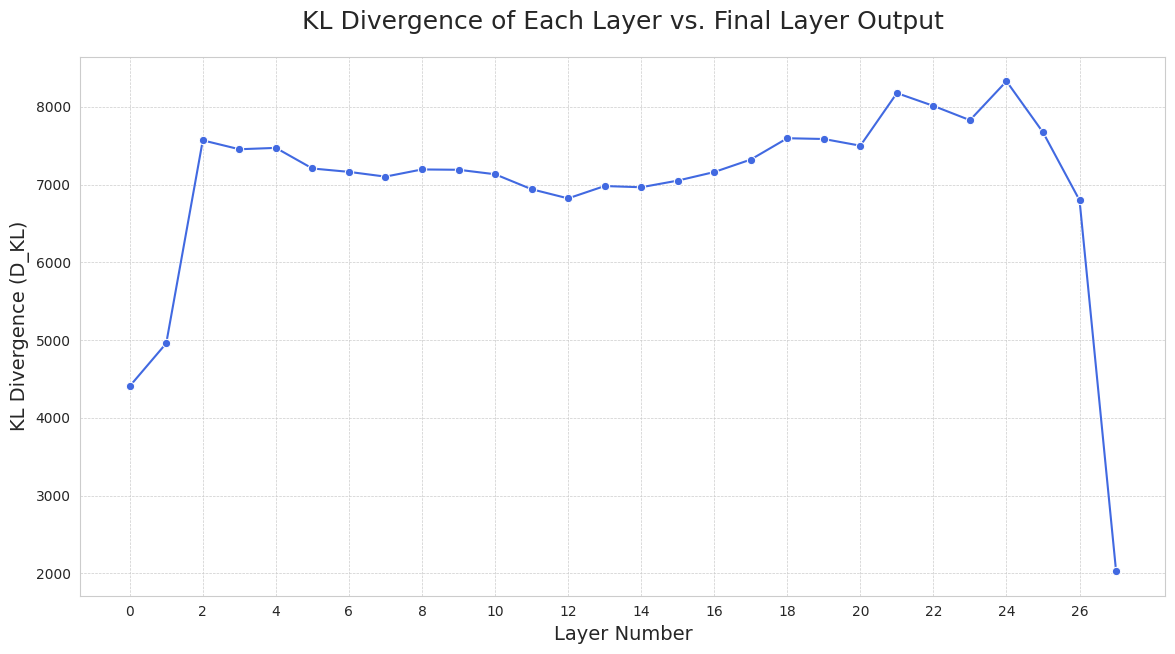

In [27]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'output_df' is the DataFrame created in the previous step
# If not, you would load it from a file, e.g., output_df = pd.read_pickle("model_outputs.pkl")

# --- 1. Prepare Data and Define KL Divergence Function ---

# The logits from the final layer ('Final Norm') are our reference distribution.
# We'll compare every other layer against this one.
final_layer_logits = output_df.loc['Final Norm']['logits'].to(device)

def calculate_kl_divergence(source_logits, target_logits):
    """
    Calculates the KL Divergence between two logit tensors.
    D_KL(P || Q) where P is from the source layer and Q is from the target (final) layer.
    """
    # Convert logits to log-probabilities for the source (P)
    # The 'input' for kl_div must be in log-space.
    log_probs_source = F.log_softmax(source_logits, dim=-1)

    # Convert logits to probabilities for the target (Q)
    # The 'target' for kl_div must be a probability distribution.
    probs_target = F.softmax(target_logits, dim=-1)

    # Calculate KL divergence. The 'batchmean' reduction averages the divergence
    # over the sequence and vocabulary dimensions.
    kl_div = F.kl_div(log_probs_source, probs_target, reduction='batchmean')
    
    return kl_div.item()

# --- 2. Calculate KL Divergence for Each Layer ---

kl_results = []
# Iterate through the DataFrame, excluding the final layer itself
for layer_num, row in output_df.drop('Final Norm').iterrows():
    layer_logits = row['logits'].to(device)
    
    # Calculate divergence between the current layer and the final layer
    divergence = calculate_kl_divergence(layer_logits, final_layer_logits)
    
    kl_results.append({
        "layer_num": int(layer_num),
        "kl_divergence": divergence
    })

# Create a new DataFrame for the KL results
kl_df = pd.DataFrame(kl_results).set_index('layer_num').sort_index()


# --- 3. Plot the Results ---

# Set a nice style for the plot
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# Create the line plot
ax = sns.lineplot(x=kl_df.index, y=kl_df['kl_divergence'], marker='o', color='royalblue')

# Set titles and labels for clarity
ax.set_title('KL Divergence of Each Layer vs. Final Layer Output', fontsize=18, pad=20)
ax.set_xlabel('Layer Number', fontsize=14)
ax.set_ylabel('KL Divergence (D_KL)', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ensure x-axis ticks are integers
plt.xticks(range(0, len(kl_df.index), 2)) # Show a tick every 2 layers

print("\nKL Divergence Results:")
print(kl_df)

# Show the plot
plt.show()


DataFrame with KL Divergence and Early Exit Probabilities:
           kl_divergence  avg_continue_prob
layer_num                                  
0            4407.622070           0.999930
1            4959.340820           0.999874
2            7568.788086           0.999707
3            7454.158691           0.998912
4            7471.760742           0.995982
5            7206.881836           0.996422
6            7163.305176           0.996434
7            7102.174805           0.995927
8            7194.442383           0.996190
9            7190.283691           0.995522
10           7132.852539           0.995629
11           6940.378906           0.994188
12           6822.260254           0.992576
13           6981.065918           0.990700
14           6965.600098           0.988205
15           7050.855469           0.986936
16           7161.019531           0.985468
17           7321.584961           0.979178
18           7595.894531           0.973293
19           758

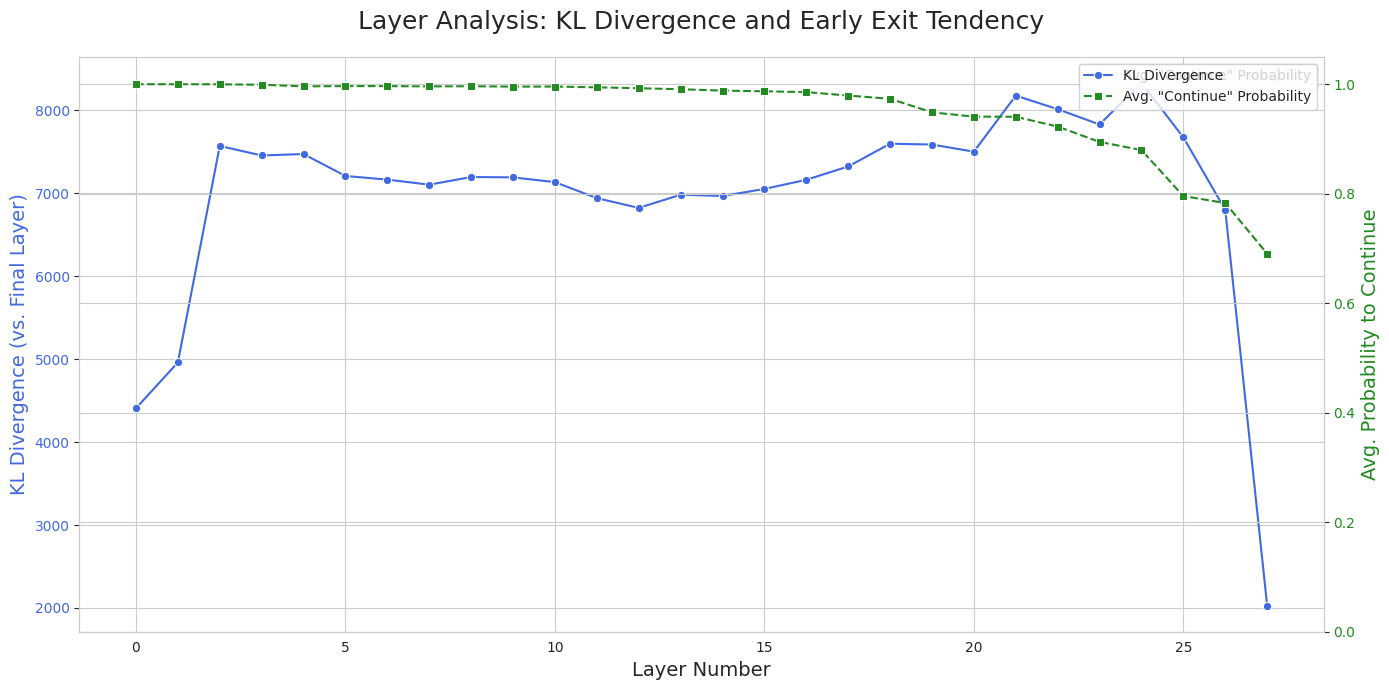

In [33]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'kl_df' and 'early_exit_probs' are available from the previous steps.

# --- 1. Calculate the Average "Continue" Probability for Each Layer ---

# The probability to continue is the second element in the last dimension (index 1)
# Shape: [num_layers, sequence_length, 2] -> [num_layers, sequence_length]
continue_probs_per_step = early_exit_probs[:, :, 1]

# Average the "continue" probability across the entire sequence for each layer
# Shape: [num_layers, sequence_length] -> [num_layers]
avg_continue_prob = torch.mean(continue_probs_per_step, dim=1).cpu().numpy()

# Add this new metric to our KL divergence DataFrame for easy plotting
# The number of layers in early_exit_probs should match the kl_df index
kl_df['avg_continue_prob'] = avg_continue_prob

print("\nDataFrame with KL Divergence and Early Exit Probabilities:")
print(kl_df)


# --- 2. Create a Dual-Axis Plot for Comparison ---

# Set a nice style for the plot
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot KL Divergence on the primary y-axis (left)
sns.lineplot(
    data=kl_df,
    x=kl_df.index,
    y='kl_divergence',
    ax=ax1,
    color='royalblue',
    marker='o',
    label='KL Divergence'
)
ax1.set_xlabel('Layer Number', fontsize=14)
ax1.set_ylabel('KL Divergence (vs. Final Layer)', color='royalblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='royalblue')

# Create a secondary y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot Average Continue Probability on the secondary y-axis (right)
sns.lineplot(
    data=kl_df,
    x=kl_df.index,
    y='avg_continue_prob',
    ax=ax2,
    color='forestgreen',
    marker='s',
    linestyle='--',
    label='Avg. "Continue" Probability'
)
ax2.set_ylabel('Avg. Probability to Continue', color='forestgreen', fontsize=14)
ax2.tick_params(axis='y', labelcolor='forestgreen')
ax2.set_ylim(0, 1.05) # Probabilities are between 0 and 1

# Final Touches
plt.title('Layer Analysis: KL Divergence and Early Exit Tendency', fontsize=18, pad=20)
fig.tight_layout() # Adjust layout to prevent labels from overlapping
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()